# Exercise 3
## Generative adversarial networks
### Generating of MNIST digits with a GAN

First we import the modules we need

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets

Check that we're running on GPU, and initialize our device

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


Setup our MNIST dataloaders

In [3]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



C:\Users\ander\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Implement your **generator** network as a fully connected neural network.

You could start with a network that:
* takes as input a 100 long vector
* has four hidden layers with 2848 neurons
* uses LeakyReLU as the activation function
* uses BatchNorm
* has Tanh as the last layer (we work with MNIST in the -1 to 1 range)

In [4]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.genboi = nn.Sequential(
        
        nn.Linear(100, 2848),
        nn.BatchNorm1d(2848),
        nn.LeakyReLU(0.2),

        nn.Linear(2848, 2848),
        nn.BatchNorm1d(2848),
        nn.LeakyReLU(0.2),
            
        nn.Linear(2848, 2848),
        nn.BatchNorm1d(2848),
        nn.LeakyReLU(0.2),
            
        nn.Linear(2848, 2848),
        nn.BatchNorm1d(2848),
        nn.LeakyReLU(0.2),
            
        nn.Linear( 2848, 28**2),
        nn.Tanh()
            
                                )
            
        
    def forward(self, x):
        x = self.genboi(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x
    

Implement your **discriminator** network as a fully connected neural network

Start out with a network that
* takes as input an $28\times28$ image
* has three hidden layers with [1024, 512, 256] neurons respectively
* uses LeakyReLU as the activation function
* uses Dropout
* has no activation on the final layer (we will call sigmoid if we want a probability)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            nn.Linear(28*28, 1024),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024,512),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 256),
            nn.Dropout(p=0.2),            
            nn.Linear(256, 1),
            
            
         
          #  nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.disc(x)
        return x

print(Discriminator())

Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


Now let's train our model

KeyboardInterrupt: 

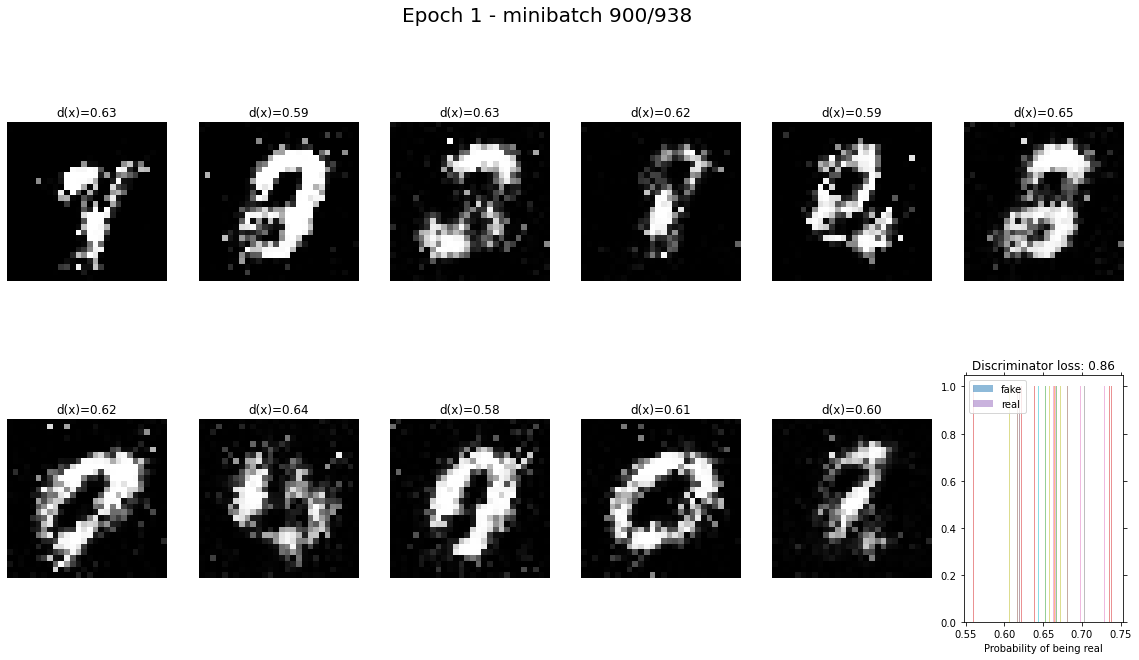

In [6]:
#Initialize networks
d = Discriminator().to(device)
g = Generator().to(device)
d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
discriminator_final_layer = torch.sigmoid

for epoch in range(num_epochs):
    for minibatch_no, (x, target) in enumerate(train_loader):
        x_real = x.to(device)*2-1 #scale to (-1, 1) range
        z = torch.randn(x.shape[0], 100).to(device)
        x_fake = g(z) 

        d_fake = d(x_fake)
        d_real = d(x_real)
        label_f = torch.zeros(d_fake.size(0)).unsqueeze(1).float().to(device)
        label_t = torch.ones(d_real.size(0)).unsqueeze(1).float().to(device)
        #Update discriminator
        
        d.zero_grad()
        
        loser = nn.L1Loss()
        
        real_loss = loser(d(x_real), label_t)
        fake_loss = loser(d(x_fake), label_f )
        
        d_loss = real_loss + fake_loss
        d_loss.backward( retain_graph = True )
        d_opt.step()

        #Update generator
        g.zero_grad()
        loss_gen = nn.BCEWithLogitsLoss()
        
        g_loss = loss_gen(d(x_fake), label_t ) 
        g_loss.backward( retain_graph = True )
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot results every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad():
                P = discriminator_final_layer(d(x_fake))
                for k in range(11):
                    x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(x_fake_k, cmap='gray')
                    subplots[k].set_title('d(x)=%.2f' % P[k])
                    subplots[k].axis('off')
                z = torch.randn(batch_size, 100).to(device)
                H1 = discriminator_final_layer(d(g(z))).cpu()
                H2 = discriminator_final_layer(d(x_real)).cpu()
                plot_min = min(H1.min(), H2.min()).item()
                plot_max = max(H1.max(), H2.max()).item()
                subplots[-1].cla()
                subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].legend()
                subplots[-1].set_xlabel('Probability of being real')
                subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())
                
                title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                plt.gcf().suptitle(title, fontsize=20)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                

Do you get a model to generate nice images?

The plot shows probabilities of real and generated digits being classified as real. Is the discriminator able to distinguish real from fake? If not, try increasing the capacity of the discriminator.
Feel free to change the architecture as you see fit.

## Additional tasks
* Change the architecture to get better results
* Implement an LSGAN
* Implement a WGAN with SN
* Convert your network to a DCGAN
* Visualize what happens when you interpolate between to points in the latent space
* Generate images from FashionMNIST

### Harder tasks:
* Add data augmentation to fake and real images
* Use the data augmentation to the generated images 
* Convert your architecture into an AC-GAN